## **Installing Ultralytics for Using Pre-trained Yolo Models**

In [1]:
# Install the ultralytics package from PyPI
!pip install ultralytics
!pip install roboflow


import ultralytics
ultralytics.checks()

Ultralytics 8.3.33 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA H100 80GB HBM3, 80995MiB)
Setup complete ✅ (224 CPUs, 2015.5 GB RAM, 195.8/1758.7 GB disk)


# **Importing Used Libraries, Setting Seed for Reproducibility and Creating Local for Saving Runs**

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import random
import torch ## PyTorch
from itertools import islice
from ultralytics import YOLO
import pandas as pd
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image
import os


## For selective classification
import warnings
# Suppress the specific sklearn warning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# Setting the random seed for reproducibility
seed = 0
np.random.seed(seed) ## for numpy
torch.manual_seed(seed) ## for PyTorch
torch.cuda.manual_seed(seed)
random.seed(0) ## for random module on python


# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## use gpu if its available

GPU is available.
Number of GPUs available: 8
GPU 0: NVIDIA H100 80GB HBM3
GPU 1: NVIDIA H100 80GB HBM3
GPU 2: NVIDIA H100 80GB HBM3
GPU 3: NVIDIA H100 80GB HBM3
GPU 4: NVIDIA H100 80GB HBM3
GPU 5: NVIDIA H100 80GB HBM3
GPU 6: NVIDIA H100 80GB HBM3
GPU 7: NVIDIA H100 80GB HBM3


### Downloading our own Dataset (Hosted on Roboflow)

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="n9Ub1kwzNqDB4Igo6gah")
project = rf.workspace("compvisionprojectufsc").project("obj_detection_autonomousdriving")
version = project.version(1)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Obj_Detection_AutonomousDriving-1 in yolov11:: 100%|██████████| 2906/2906 [00:00<00:00, 13221.84it/s]


# **1 - (OLD) Loading and Preparing the Data (EDA of KITTI dataset)**

In [3]:
## uses the kitti-dataset-yolo-format file to convert to acceptable yolo inputs
!cat ./Obj_Detection_AutonomousDriving-1/data.yaml

path: /lapix/Comp_Vision_Final_Project/Computer_Vision/Obj_Detection_AutonomousDriving-1/
train: ./train/images
val: ./valid/images
test: ./test/images

nc: 8
names: ['Bicycle', 'Bus', 'Car', 'Motorcycle', 'Person', 'Sign', 'TrafficLight', 'Truck']

roboflow:
  workspace: compvisionprojectufsc
  project: obj_detection_autonomousdriving
  version: 1
  license: MIT
  url: https://universe.roboflow.com/compvisionprojectufsc/obj_detection_autonomousdriving/dataset/1

In [4]:
files_train = os.listdir("./Obj_Detection_AutonomousDriving-1/train/images/")
files_val = os.listdir("./Obj_Detection_AutonomousDriving-1/valid/images/")
files_test = os.listdir("./Obj_Detection_AutonomousDriving-1/test/images/")

print(f'Training dataset: {len(files_train)} samples')
print(f'Validation dataset: {len(files_val)} samples')
print(f'Test dataset: {len(files_test)} samples')

Training dataset: 1110 samples
Validation dataset: 244 samples
Test dataset: 93 samples


# **2 - Choosing Model, Training/Validation Steps**

## **Instantiating the Model**

In [5]:
# Load a model
model = YOLO("yolo11m.yaml")  # build a new model from YAML
#model = YOLO("yolo11m.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11m.yaml").load("yolo11m.pt")  # build from YAML and transfer weights
#model = YOLO("/kaggle/working/yolo11s-kitti/train/weights/best.pt")  # load a custom model


Transferred 649/649 items from pretrained weights


## **Training on Custon Dataset (NEW Approach)**

In [6]:
# Train the model
train_results = model.train(
    data="./Obj_Detection_AutonomousDriving-1/data.yaml",  # path to dataset YAML
    epochs=200,  # number of training epochs
    imgsz=640,  # training image size
    device=0,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    project="yolo11m_finetunned",
    exist_ok=True
)

New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.33 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA H100 80GB HBM3, 80995MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.yaml, data=./Obj_Detection_AutonomousDriving-1/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo11m_finetunned, name=train, exist_ok=True, pretrained=yolo11m.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /lapix/Comp_Vision_Final_Project/Computer_Vision/Obj_Detection_AutonomousDriving-1/train/labels.cache... 1110 images, 50 backgrounds, 0 corrupt: 100%|██████████| 1110/1110 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /lapix/Comp_Vision_Final_Project/Computer_Vision/Obj_Detection_AutonomousDriving-1/valid/labels.cache... 244 images, 7 backgrounds, 0 corrupt: 100%|██████████| 244/244 [00:00<?, ?it/s]


Plotting labels to yolo11m_finetunned/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo11m_finetunned/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      8.68G      1.063      1.567     0.9967         81        640: 100%|██████████| 70/70 [00:06<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.31it/s]

                   all        244       1761      0.559      0.553      0.551       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      8.67G      1.136      1.084      1.041         60        640: 100%|██████████| 70/70 [00:05<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]

                   all        244       1761      0.535      0.537      0.534      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      8.69G      1.171      1.097      1.063         88        640: 100%|██████████| 70/70 [00:05<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 12.96it/s]

                   all        244       1761      0.599      0.465      0.504      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      8.64G      1.188      1.071      1.081         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]

                   all        244       1761      0.509      0.553      0.521      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      8.68G      1.171      1.018      1.052         58        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.29it/s]

                   all        244       1761      0.606       0.55      0.581       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      8.63G      1.128     0.9551      1.048         38        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.82it/s]

                   all        244       1761      0.671      0.609      0.624      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      8.66G      1.124     0.9428      1.048         58        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]

                   all        244       1761       0.72      0.606      0.635      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      8.65G      1.123     0.9275      1.046         94        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]

                   all        244       1761      0.675      0.582      0.645      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      8.65G      1.112     0.9132       1.03         96        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.82it/s]

                   all        244       1761      0.651      0.566      0.603      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      8.61G      1.102     0.9005      1.031        111        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]

                   all        244       1761      0.703      0.602      0.644      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       8.6G       1.06     0.8506      1.013         35        640: 100%|██████████| 70/70 [00:05<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.29it/s]

                   all        244       1761      0.724      0.606      0.673      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       8.6G      1.068     0.8685      1.015        104        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.28it/s]

                   all        244       1761      0.716      0.605      0.651      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      8.69G      1.034     0.8128      1.003         86        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]

                   all        244       1761      0.683       0.64      0.674      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      8.57G      1.046      0.823      1.005         82        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.61it/s]

                   all        244       1761      0.743      0.659      0.705      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       8.7G      1.017     0.8222     0.9959         85        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]

                   all        244       1761      0.716      0.636      0.678      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      8.57G      1.022     0.8077      1.001         45        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]

                   all        244       1761       0.76      0.582      0.671      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      8.66G      1.005     0.7908     0.9909        103        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]

                   all        244       1761      0.672      0.652      0.675       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      8.63G      1.019     0.7897     0.9996         67        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]

                   all        244       1761      0.684      0.628      0.664      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      8.65G      1.009     0.7786     0.9954         92        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]

                   all        244       1761       0.65       0.71      0.701      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      8.63G     0.9738     0.7533     0.9837        103        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]

                   all        244       1761      0.733      0.644      0.717      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      8.69G     0.9928      0.773     0.9886         86        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]

                   all        244       1761      0.766      0.635        0.7      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      8.64G     0.9823     0.7505     0.9846         91        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

                   all        244       1761      0.756      0.666      0.717      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      8.69G     0.9784     0.7527     0.9819         83        640: 100%|██████████| 70/70 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]

                   all        244       1761      0.797      0.646       0.74      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      8.64G     0.9741     0.7198     0.9765         77        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

                   all        244       1761      0.761      0.666      0.729      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      8.68G      0.956     0.7335     0.9777         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]

                   all        244       1761      0.763       0.69      0.729      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      8.63G     0.9549     0.7198     0.9744         92        640: 100%|██████████| 70/70 [00:05<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]

                   all        244       1761      0.711      0.627      0.702      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      8.59G     0.9518     0.7374     0.9682        107        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]

                   all        244       1761      0.754      0.643      0.702      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      8.63G     0.9539     0.7196     0.9696         70        640: 100%|██████████| 70/70 [00:05<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.59it/s]

                   all        244       1761      0.718      0.649      0.704      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      8.64G      0.932     0.7029     0.9671         42        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.48it/s]

                   all        244       1761      0.793      0.629      0.721       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      8.55G     0.9233     0.6946     0.9609         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]

                   all        244       1761      0.808      0.653       0.73      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      8.68G     0.9354     0.6858     0.9608         68        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]

                   all        244       1761      0.779      0.649      0.717      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      8.63G     0.9167     0.6785     0.9499         98        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.63it/s]

                   all        244       1761      0.735      0.706      0.734      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      8.68G     0.9061     0.6614     0.9547         65        640: 100%|██████████| 70/70 [00:05<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

                   all        244       1761      0.784      0.706      0.753      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      8.66G     0.9091     0.6691     0.9513         96        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.722      0.681      0.734      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      8.68G     0.9229     0.6715      0.957         70        640: 100%|██████████| 70/70 [00:05<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]

                   all        244       1761      0.787       0.68      0.762      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200       8.6G     0.9054     0.6525     0.9533         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.62it/s]

                   all        244       1761      0.773      0.652      0.709      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      8.66G     0.8914     0.6628      0.948         46        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

                   all        244       1761        0.8      0.651      0.723      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      8.64G     0.9029     0.6686     0.9513         46        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.63it/s]

                   all        244       1761       0.77      0.682      0.742      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      8.63G      0.895     0.6533     0.9476         77        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.61it/s]

                   all        244       1761      0.772      0.704      0.746      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      8.64G     0.8828     0.6489     0.9426         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.56it/s]

                   all        244       1761      0.761      0.704      0.749      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      8.69G     0.8972     0.6657     0.9465         71        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.70it/s]

                   all        244       1761      0.736      0.732      0.761      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      8.56G      0.899     0.6704     0.9454         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.63it/s]

                   all        244       1761      0.811      0.698      0.768      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      8.67G     0.8755      0.636     0.9426         73        640: 100%|██████████| 70/70 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

                   all        244       1761      0.772      0.693      0.758      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      8.57G     0.8885      0.632     0.9418         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]

                   all        244       1761      0.731       0.73      0.763      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      8.67G     0.8887     0.6455     0.9407         57        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761      0.717      0.708      0.739      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      8.66G     0.8639     0.6317      0.936         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.67it/s]

                   all        244       1761      0.804      0.668      0.751      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      8.66G     0.8707     0.6241      0.938         41        640: 100%|██████████| 70/70 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]

                   all        244       1761      0.817       0.65      0.754      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      8.62G      0.856     0.6184     0.9309         84        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

                   all        244       1761      0.745      0.711      0.764      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      8.68G      0.862     0.6193     0.9363         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.60it/s]

                   all        244       1761      0.773      0.691      0.775      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      8.61G      0.863     0.6174     0.9289         95        640: 100%|██████████| 70/70 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761       0.75      0.719      0.763      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      8.66G     0.8545     0.6078     0.9296         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

                   all        244       1761      0.742      0.703      0.749      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      8.59G     0.8514     0.6017     0.9262         42        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761        0.8       0.68      0.752      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      8.69G      0.829     0.5813     0.9258         61        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]

                   all        244       1761      0.808      0.674      0.757      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      8.65G     0.8466     0.5932     0.9298         57        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

                   all        244       1761      0.766      0.678      0.741      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      8.61G     0.8482      0.595      0.932        104        640: 100%|██████████| 70/70 [00:05<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.798      0.656      0.745      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      8.64G     0.8518     0.5917     0.9295         54        640: 100%|██████████| 70/70 [00:05<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]

                   all        244       1761      0.761      0.754      0.776       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      8.68G     0.8401     0.5905     0.9213         72        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.62it/s]

                   all        244       1761      0.772      0.732      0.781      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      8.62G     0.8412     0.5833     0.9241        110        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.769      0.716      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      8.71G     0.8311     0.5944     0.9253         63        640: 100%|██████████| 70/70 [00:05<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

                   all        244       1761      0.817      0.676      0.754      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      8.64G     0.8333     0.5736     0.9219         76        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.771       0.72      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      8.69G     0.8052     0.5708     0.9166         77        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]

                   all        244       1761      0.715      0.718      0.743       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      8.63G     0.8214     0.5753     0.9197         71        640: 100%|██████████| 70/70 [00:05<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761      0.793       0.68      0.768      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      8.68G      0.817     0.5736     0.9187         46        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]

                   all        244       1761       0.77      0.747      0.794      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      8.64G     0.8162     0.5659     0.9202         74        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

                   all        244       1761      0.793      0.699      0.775       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      8.69G     0.8088     0.5794     0.9124         96        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.755      0.758      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      8.64G     0.8099     0.5588     0.9121         76        640: 100%|██████████| 70/70 [00:05<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761      0.743      0.739      0.767      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      8.59G     0.8011      0.548     0.9136        111        640: 100%|██████████| 70/70 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761      0.781      0.696      0.767      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      8.66G     0.7992     0.5489     0.9093         65        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761      0.804      0.717        0.8      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      8.68G     0.8019     0.5438     0.9127        103        640: 100%|██████████| 70/70 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]

                   all        244       1761      0.734      0.751      0.773      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      8.66G     0.8086     0.5499     0.9114         84        640: 100%|██████████| 70/70 [00:05<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

                   all        244       1761      0.763      0.716      0.765      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       8.7G     0.7936      0.537     0.9059         61        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]

                   all        244       1761      0.785      0.748      0.779       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      8.65G     0.7859     0.5403     0.9071         24        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

                   all        244       1761      0.717      0.725      0.752      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      8.68G     0.7777     0.5388     0.9016         52        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.65it/s]

                   all        244       1761      0.792      0.701      0.766      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      8.65G     0.7972     0.5387      0.908         78        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.66it/s]

                   all        244       1761      0.755      0.733      0.766      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      8.68G      0.785     0.5341     0.9038         80        640: 100%|██████████| 70/70 [00:05<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761       0.79      0.697      0.769      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      8.62G     0.7727     0.5256     0.9006         65        640: 100%|██████████| 70/70 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.66it/s]

                   all        244       1761      0.766      0.724       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      8.65G     0.7679     0.5244     0.8939         70        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.773      0.728      0.772      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      8.65G     0.7599      0.519     0.8999         66        640: 100%|██████████| 70/70 [00:05<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.773      0.704      0.772      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      8.71G      0.765     0.5279     0.9037         81        640: 100%|██████████| 70/70 [00:05<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.833      0.705      0.778      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      8.56G     0.7593     0.5175     0.9019         49        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761      0.775      0.706      0.773      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      8.69G     0.7583     0.5168     0.8986         86        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761      0.743      0.771      0.794      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      8.65G     0.7618     0.5199     0.8966         90        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761      0.738      0.726      0.758      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       8.6G     0.7817     0.5219     0.9039         72        640: 100%|██████████| 70/70 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

                   all        244       1761      0.803      0.721      0.785      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      8.62G     0.7555     0.5066     0.8943         79        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.798      0.724       0.77      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      8.68G     0.7604     0.5159     0.8954         89        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.71it/s]

                   all        244       1761      0.718      0.752      0.769       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      8.65G     0.7626     0.5103      0.891         69        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

                   all        244       1761      0.729      0.734      0.783      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      8.68G     0.7637     0.5096      0.892         73        640: 100%|██████████| 70/70 [00:05<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]

                   all        244       1761      0.774      0.756      0.779      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      8.64G     0.7546     0.5036     0.8928         95        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761      0.756       0.72      0.758      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      8.61G     0.7464      0.495     0.8922         35        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]

                   all        244       1761      0.762       0.76      0.787      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      8.63G     0.7417     0.5002     0.8919         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761       0.81      0.723      0.784      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      8.69G     0.7362      0.501     0.8904         47        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761      0.758      0.747      0.795      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      8.57G     0.7629      0.506     0.8969         47        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.797      0.724      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      8.69G     0.7327     0.4928     0.8904         47        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.66it/s]

                   all        244       1761      0.802      0.737      0.782      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      8.65G     0.7409     0.4849     0.8907         67        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]

                   all        244       1761      0.764      0.753       0.77      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      8.59G     0.7452     0.4939     0.8979         30        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.757      0.751      0.768      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      8.57G     0.7353     0.4828     0.8863         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.784      0.718       0.78      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      8.68G      0.723     0.4814     0.8815         62        640: 100%|██████████| 70/70 [00:05<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761      0.774      0.752      0.777      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      8.63G     0.7258     0.4814     0.8874         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

                   all        244       1761      0.734      0.795      0.779      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      8.67G     0.7256     0.4881     0.8869         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]

                   all        244       1761      0.736      0.781      0.783      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      8.63G     0.7074     0.4717     0.8816         61        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761      0.768      0.704      0.762      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      8.61G     0.7304     0.4906     0.8848         55        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761      0.763      0.731      0.769      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      8.58G     0.7128     0.4699      0.881        120        640: 100%|██████████| 70/70 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]

                   all        244       1761      0.767      0.746      0.772      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      8.69G     0.7108     0.4693     0.8826         47        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761      0.788      0.732      0.772      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      8.65G     0.7182     0.4665      0.881         78        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

                   all        244       1761      0.778      0.716      0.768      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       8.7G     0.7081     0.4555     0.8724         94        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.87it/s]

                   all        244       1761      0.775      0.736      0.768      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      8.63G     0.7053     0.4573     0.8792         81        640: 100%|██████████| 70/70 [00:05<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.771      0.757      0.783      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      8.69G     0.6981     0.4603     0.8787         87        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.795      0.717       0.77      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      8.56G     0.7012     0.4648     0.8771         60        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761      0.781       0.74      0.782      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      8.62G     0.7075     0.4524     0.8793        120        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

                   all        244       1761      0.738      0.769      0.779      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      8.65G     0.7016     0.4626     0.8803         79        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.91it/s]

                   all        244       1761      0.784      0.723      0.773      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      8.63G      0.691     0.4519     0.8778         35        640: 100%|██████████| 70/70 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761      0.805      0.735      0.772      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      8.65G     0.6926     0.4502      0.881         52        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]

                   all        244       1761      0.798      0.745      0.797      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      8.68G     0.6933     0.4511     0.8756         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.787      0.745      0.772      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      8.62G     0.6919      0.451     0.8684         56        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.791      0.712      0.782       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      8.68G     0.6871     0.4444     0.8726         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.79it/s]

                   all        244       1761      0.753      0.754      0.764      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       8.6G     0.6877     0.4493     0.8716         60        640: 100%|██████████| 70/70 [00:05<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.771      0.728      0.757      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      8.62G     0.6806     0.4419     0.8704         84        640: 100%|██████████| 70/70 [00:05<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.789      0.735      0.766      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      8.57G     0.6819     0.4484     0.8738         72        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]

                   all        244       1761      0.761      0.743      0.757      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      8.69G     0.6702     0.4331     0.8737         78        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.93it/s]

                   all        244       1761      0.761      0.775      0.776      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      8.65G     0.6678     0.4336     0.8705        112        640: 100%|██████████| 70/70 [00:05<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.783      0.753      0.775       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      8.68G     0.6744     0.4363     0.8728         45        640: 100%|██████████| 70/70 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.90it/s]

                   all        244       1761      0.807      0.743       0.79       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      8.63G     0.6692     0.4311     0.8697         57        640: 100%|██████████| 70/70 [00:05<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.786      0.764        0.8      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      8.68G     0.6676     0.4285     0.8688         63        640: 100%|██████████| 70/70 [00:05<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.87it/s]

                   all        244       1761      0.784      0.738      0.768       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      8.63G     0.6581     0.4262     0.8673         63        640: 100%|██████████| 70/70 [00:05<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.56it/s]

                   all        244       1761      0.785      0.736      0.782      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      8.68G     0.6597     0.4159     0.8627         96        640: 100%|██████████| 70/70 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]

                   all        244       1761      0.825      0.717      0.793      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      8.58G     0.6573     0.4236     0.8675         52        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761       0.79      0.741      0.788      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      8.62G     0.6582     0.4155     0.8682         49        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.785      0.743      0.778      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      8.65G       0.65     0.4143     0.8644         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.778       0.76      0.774      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      8.69G     0.6621     0.4244      0.864         97        640: 100%|██████████| 70/70 [00:05<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.90it/s]

                   all        244       1761      0.787      0.706      0.755      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      8.65G     0.6518      0.417     0.8682         86        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

                   all        244       1761      0.776       0.74      0.778      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      8.67G     0.6464     0.4145     0.8644         66        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]

                   all        244       1761       0.77      0.726       0.76      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      8.61G     0.6455       0.41     0.8655         68        640: 100%|██████████| 70/70 [00:05<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.766      0.732      0.773      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      8.69G     0.6415     0.3967     0.8568         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.807      0.703      0.755      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      8.65G     0.6297     0.3983     0.8591         62        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.76it/s]

                   all        244       1761        0.8      0.734      0.777      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      8.68G     0.6406     0.4008     0.8575         72        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.772      0.761      0.793      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      8.59G     0.6372     0.4009     0.8579        104        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.752      0.777      0.787       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      8.67G     0.6372      0.404     0.8574         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.783      0.781      0.796      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      8.65G       0.63     0.4008     0.8602         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.84it/s]

                   all        244       1761      0.776      0.774      0.782      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      8.71G     0.6322     0.4059     0.8613         62        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761       0.76      0.777      0.776      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      8.56G     0.6217     0.4009     0.8627         66        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.79it/s]

                   all        244       1761      0.762      0.781      0.781      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      8.68G     0.6197     0.3955     0.8538         79        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.90it/s]

                   all        244       1761      0.774      0.767      0.777      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      8.65G     0.6216     0.3943     0.8561         60        640: 100%|██████████| 70/70 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

                   all        244       1761       0.78      0.737      0.768      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      8.67G     0.6167     0.3955     0.8586         64        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.97it/s]

                   all        244       1761      0.781      0.755      0.774      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      8.65G     0.6149     0.3928     0.8517         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.783      0.746      0.778      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      8.66G     0.6114       0.39     0.8532         95        640: 100%|██████████| 70/70 [00:05<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761      0.783      0.742       0.77      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      8.63G     0.6139     0.3903     0.8538         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.75it/s]

                   all        244       1761      0.784       0.74      0.778      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      8.69G     0.6139     0.3859     0.8549         77        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]

                   all        244       1761      0.794      0.774      0.794      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      8.65G     0.6052      0.382     0.8538        148        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.68it/s]

                   all        244       1761      0.783      0.751      0.768      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      8.69G     0.6033     0.3854     0.8532         68        640: 100%|██████████| 70/70 [00:05<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.802      0.728      0.771      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      8.65G     0.6091     0.3859     0.8534         49        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]

                   all        244       1761      0.792      0.773      0.791      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      8.68G      0.605     0.3834     0.8518         93        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761        0.8      0.731      0.775       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      8.65G     0.6039     0.3781      0.852         87        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]

                   all        244       1761      0.768      0.799      0.789      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      8.65G     0.5903     0.3742     0.8467         57        640: 100%|██████████| 70/70 [00:05<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]

                   all        244       1761      0.799      0.734      0.764      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      8.63G     0.5893     0.3684     0.8483         65        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]

                   all        244       1761      0.785      0.754       0.78      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       8.7G     0.5865     0.3684     0.8469        117        640: 100%|██████████| 70/70 [00:05<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.71it/s]

                   all        244       1761      0.794      0.744      0.771      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      8.65G     0.5774     0.3681     0.8456         71        640: 100%|██████████| 70/70 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]

                   all        244       1761        0.8       0.73      0.785      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      8.67G     0.5875     0.3638      0.843         83        640: 100%|██████████| 70/70 [00:05<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

                   all        244       1761      0.765      0.771       0.79      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      8.63G     0.5879     0.3703     0.8466         43        640: 100%|██████████| 70/70 [00:05<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]

                   all        244       1761      0.775      0.744      0.779      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      8.67G     0.5808     0.3625     0.8456         97        640: 100%|██████████| 70/70 [00:05<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.22it/s]

                   all        244       1761      0.802      0.738      0.796      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      8.65G     0.5817     0.3648      0.847        109        640: 100%|██████████| 70/70 [00:05<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.59it/s]

                   all        244       1761      0.765      0.781      0.797      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      8.68G     0.5758     0.3659     0.8428         92        640: 100%|██████████| 70/70 [00:05<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.61it/s]

                   all        244       1761      0.786      0.759      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      8.56G     0.5765     0.3583     0.8428        101        640: 100%|██████████| 70/70 [00:05<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.56it/s]

                   all        244       1761      0.787      0.745      0.795      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      8.64G      0.577      0.363     0.8456         65        640: 100%|██████████| 70/70 [00:05<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]

                   all        244       1761      0.767      0.739      0.775      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      8.64G     0.5758     0.3634     0.8476         96        640: 100%|██████████| 70/70 [00:05<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.41it/s]

                   all        244       1761      0.782      0.743      0.781       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200       8.7G     0.5686     0.3558     0.8434         56        640: 100%|██████████| 70/70 [00:05<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]

                   all        244       1761      0.789       0.75      0.788      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      8.65G     0.5841     0.3637     0.8481         47        640: 100%|██████████| 70/70 [00:05<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]

                   all        244       1761      0.793      0.744      0.789      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      8.63G     0.5655     0.3542     0.8382         97        640: 100%|██████████| 70/70 [00:05<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.45it/s]

                   all        244       1761      0.787      0.746      0.784      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      8.65G     0.5623     0.3577     0.8392         55        640: 100%|██████████| 70/70 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.50it/s]

                   all        244       1761      0.782      0.756       0.78      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      8.68G     0.5673     0.3533     0.8431         61        640: 100%|██████████| 70/70 [00:05<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

                   all        244       1761      0.794      0.745      0.787      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      8.63G     0.5639     0.3493     0.8419         53        640: 100%|██████████| 70/70 [00:05<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.90it/s]

                   all        244       1761      0.777      0.753      0.778      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       8.7G     0.5628     0.3483     0.8403         77        640: 100%|██████████| 70/70 [00:05<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.80it/s]

                   all        244       1761      0.793      0.726      0.783      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      8.64G     0.5592     0.3484     0.8391         50        640: 100%|██████████| 70/70 [00:05<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]

                   all        244       1761      0.793      0.745      0.789      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      8.68G     0.5538     0.3483     0.8398         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]

                   all        244       1761      0.793      0.752      0.784      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      8.65G     0.5432     0.3395     0.8362        103        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]

                   all        244       1761      0.783      0.732      0.772      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      8.59G     0.5537     0.3411     0.8417         67        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]

                   all        244       1761      0.783      0.745      0.784      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      8.63G     0.5463     0.3413     0.8386         66        640: 100%|██████████| 70/70 [00:05<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

                   all        244       1761      0.784      0.748      0.774       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      8.71G      0.545     0.3423     0.8361         40        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.93it/s]

                   all        244       1761      0.787      0.762      0.779      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      8.65G     0.5429     0.3412      0.839         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.66it/s]

                   all        244       1761      0.793      0.741      0.781      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      8.69G     0.5476     0.3361     0.8394         83        640: 100%|██████████| 70/70 [00:05<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 15.59it/s]

                   all        244       1761      0.791      0.735       0.78      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      8.57G     0.5466     0.3394     0.8367         94        640: 100%|██████████| 70/70 [00:05<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]

                   all        244       1761      0.746      0.772      0.771      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      8.68G     0.5343     0.3356     0.8366         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.93it/s]

                   all        244       1761      0.784      0.757      0.775      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      8.63G     0.5406     0.3351     0.8366         51        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]

                   all        244       1761      0.795      0.752      0.773      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      8.68G     0.5345      0.336     0.8359        100        640: 100%|██████████| 70/70 [00:05<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.98it/s]

                   all        244       1761      0.788       0.75      0.769      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200       8.6G     0.5394      0.336     0.8353        107        640: 100%|██████████| 70/70 [00:05<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

                   all        244       1761      0.798       0.74      0.769      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      8.67G      0.538      0.334     0.8371         81        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.87it/s]

                   all        244       1761      0.801      0.733      0.774      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      8.58G     0.5204     0.3244     0.8326         72        640: 100%|██████████| 70/70 [00:05<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]

                   all        244       1761      0.762      0.764      0.776      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      8.68G     0.5306     0.3292     0.8349         59        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.05it/s]

                   all        244       1761      0.783      0.757      0.774      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      8.56G     0.5248     0.3317      0.833         75        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]

                   all        244       1761      0.777       0.76      0.776      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200       8.7G     0.5317     0.3332     0.8353         81        640: 100%|██████████| 70/70 [00:05<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.88it/s]

                   all        244       1761      0.765      0.765      0.785      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      8.65G     0.5343     0.3259     0.8336         73        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]

                   all        244       1761       0.76      0.778      0.789      0.556


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      8.69G     0.5379      0.327     0.8318         35        640: 100%|██████████| 70/70 [00:05<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]

                   all        244       1761      0.751      0.764      0.779      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      8.64G     0.5278      0.313     0.8291         39        640: 100%|██████████| 70/70 [00:05<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.95it/s]

                   all        244       1761      0.777      0.762      0.784      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      8.68G     0.5174     0.3121     0.8238         44        640: 100%|██████████| 70/70 [00:05<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.03it/s]

                   all        244       1761      0.764      0.773      0.782      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      8.64G     0.5175     0.3081     0.8241         34        640: 100%|██████████| 70/70 [00:05<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]

                   all        244       1761      0.758      0.776       0.78      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      8.68G      0.501     0.2998     0.8233         28        640: 100%|██████████| 70/70 [00:05<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.05it/s]

                   all        244       1761      0.793       0.74      0.783       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      8.63G     0.5011     0.3025     0.8246         39        640: 100%|██████████| 70/70 [00:05<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.04it/s]

                   all        244       1761      0.769      0.768      0.786      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      8.68G      0.503     0.3003     0.8229         32        640: 100%|██████████| 70/70 [00:05<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.09it/s]

                   all        244       1761       0.78      0.764      0.782      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      8.64G     0.4927     0.2981     0.8232         48        640: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 16.97it/s]

                   all        244       1761      0.784      0.761      0.782      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      8.67G     0.5001     0.2963     0.8246         45        640: 100%|██████████| 70/70 [00:05<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.07it/s]

                   all        244       1761      0.782      0.756      0.779      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      8.64G     0.5039     0.2994     0.8224         57        640: 100%|██████████| 70/70 [00:05<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00, 17.10it/s]

                   all        244       1761      0.783       0.76       0.78      0.552



200 epochs completed in 0.368 hours.
Optimizer stripped from yolo11m_finetunned/train/weights/last.pt, 40.5MB
Optimizer stripped from yolo11m_finetunned/train/weights/best.pt, 40.5MB

Validating yolo11m_finetunned/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.33 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA H100 80GB HBM3, 80995MiB)
YOLO11m summary (fused): 303 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


                   all        244       1761       0.77      0.781      0.797      0.558
               Bicycle          8          9      0.795      0.865      0.865      0.615
                   Bus         14         14      0.648      0.714      0.722      0.614
                   Car        222        978      0.795      0.769       0.82       0.64
            Motorcycle         74         96      0.744      0.792      0.782      0.371
                Person         86        139      0.779      0.719      0.774      0.429
                  Sign        161        339      0.749      0.775      0.768      0.494
          TrafficLight         20        109      0.903      0.858      0.925      0.761
                 Truck         53         77      0.745      0.753      0.721      0.539
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to yolo11m_finetunned/train


## **Validating**

In [7]:
model.val(save_json=True, project="yolo11m_finetunned", name="val")

WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.33 🚀 Python-3.11.10 torch-2.5.1+cu124 CUDA:0 (NVIDIA H100 80GB HBM3, 80995MiB)
YOLO11m summary (fused): 303 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /lapix/Comp_Vision_Final_Project/Computer_Vision/Obj_Detection_AutonomousDriving-1/valid/labels.cache... 244 images, 7 backgrounds, 0 corrupt: 100%|██████████| 244/244 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


                   all        244       1761      0.763      0.782      0.796      0.553
               Bicycle          8          9      0.796      0.869      0.865      0.586
                   Bus         14         14      0.613      0.714      0.723      0.618
                   Car        222        978      0.789      0.772      0.821      0.642
            Motorcycle         74         96      0.753      0.795      0.789      0.368
                Person         86        139       0.77      0.712      0.764      0.427
                  Sign        161        339      0.747      0.776      0.767      0.494
          TrafficLight         20        109        0.9      0.862      0.918      0.753
                 Truck         53         77      0.735      0.757      0.721       0.54
Speed: 0.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving yolo11m_finetunned/val/predictions.json...
Results saved to yolo11m_finetunned/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79ec814a8150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

## **Seeing Results from Training**

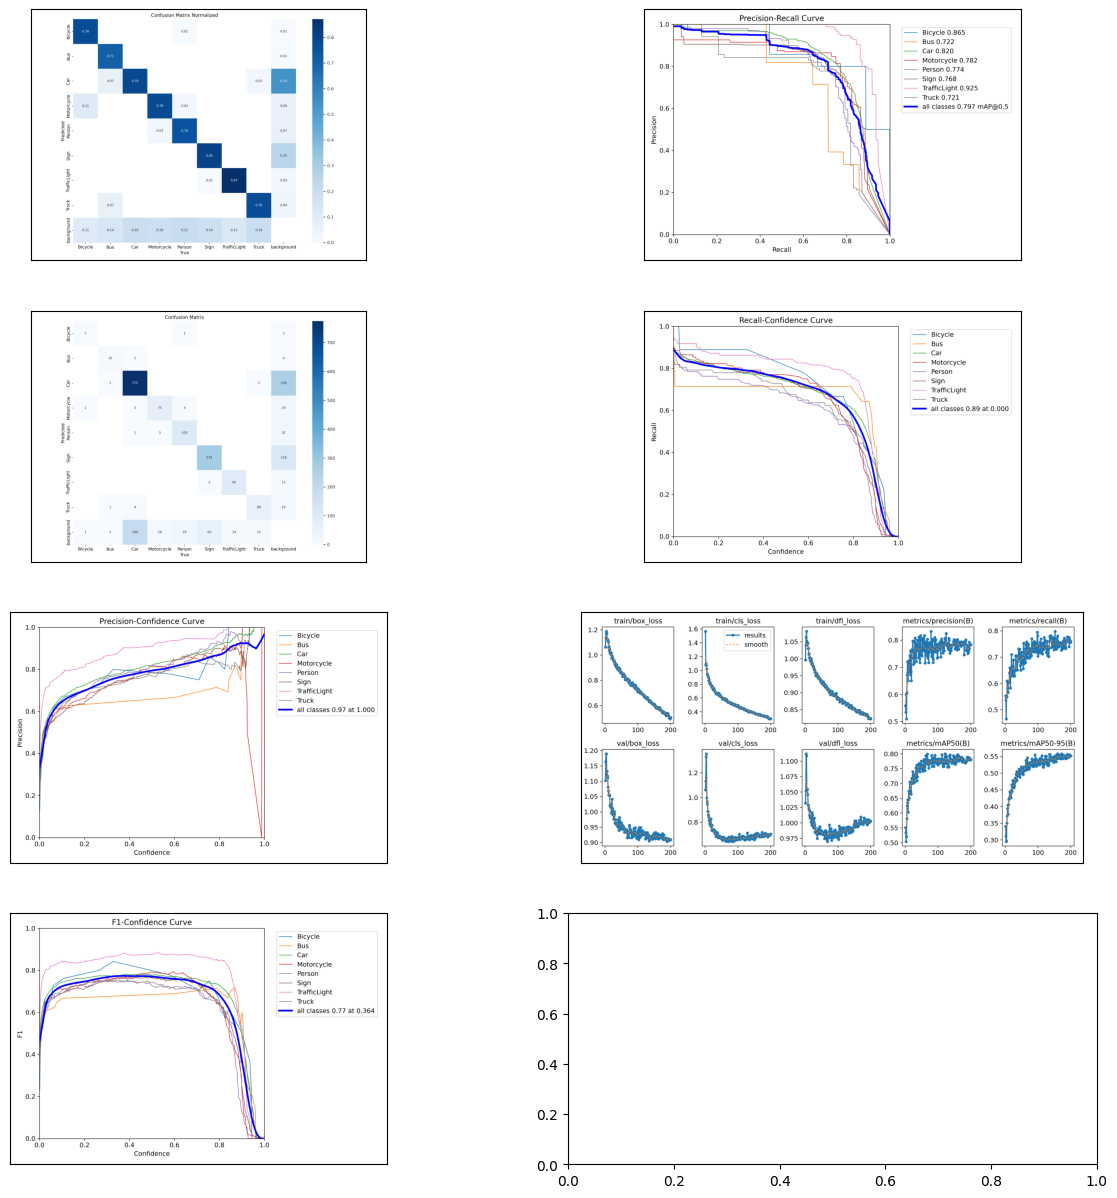

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.ticker as ticker

metrics_img = glob(os.path.join("./yolo11m_finetunned", 'train/*.png'))
n_img = len(metrics_img)
n_cols = 2
n_rows = int(n_img / n_cols) + (1 if n_img % n_cols != 0 else 0)
_, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()
for m, ax in zip(metrics_img, axs):
  img = plt.imread(m)
  ax.imshow(img)
  ax.xaxis.set_major_locator(ticker.NullLocator())
  ax.yaxis.set_major_locator(ticker.NullLocator())
plt.show()

## **Seeing Results on Validation Set**

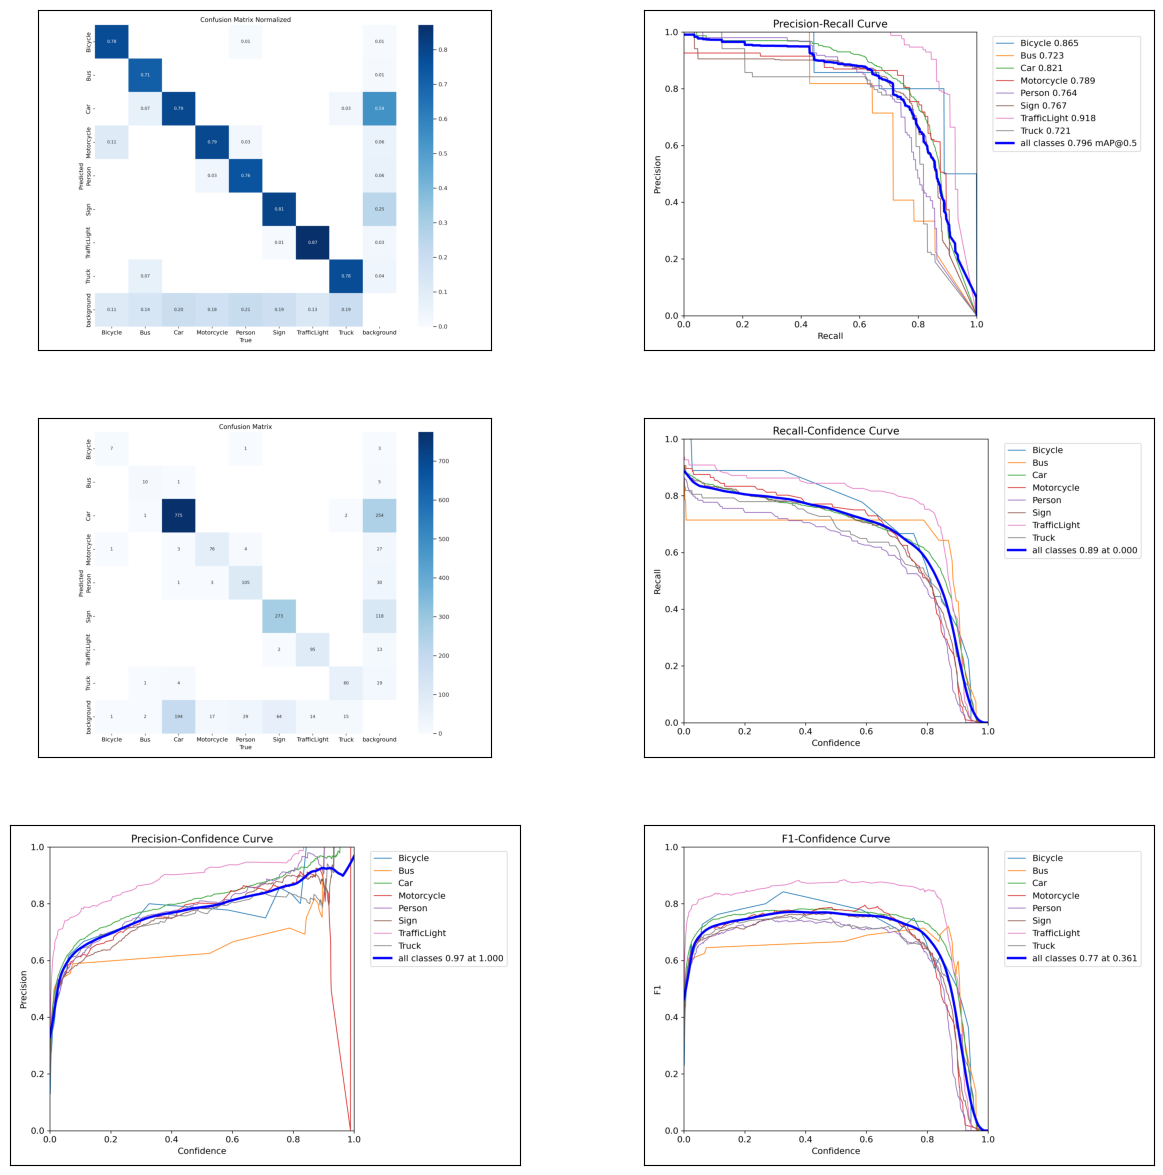

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.ticker as ticker

metrics_img = glob(os.path.join("./yolo11m_finetunned", "val/*.png"))
n_img = len(metrics_img)
n_cols = 2
n_rows = int(n_img / n_cols) + (1 if n_img % n_cols != 0 else 0)
_, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()
for m, ax in zip(metrics_img, axs):
  img = plt.imread(m)
  ax.imshow(img)
  ax.xaxis.set_major_locator(ticker.NullLocator())
  ax.yaxis.set_major_locator(ticker.NullLocator())
plt.show()

## **Seeing Predictions on Validation Set**

In [14]:
preds = list(Path('./yolo11m_finetunned/val/').glob('val_batch*_pred.jpg'))
preds

[PosixPath('yolo11m_finetunned/val/val_batch0_pred.jpg'),
 PosixPath('yolo11m_finetunned/val/val_batch2_pred.jpg'),
 PosixPath('yolo11m_finetunned/val/val_batch1_pred.jpg')]

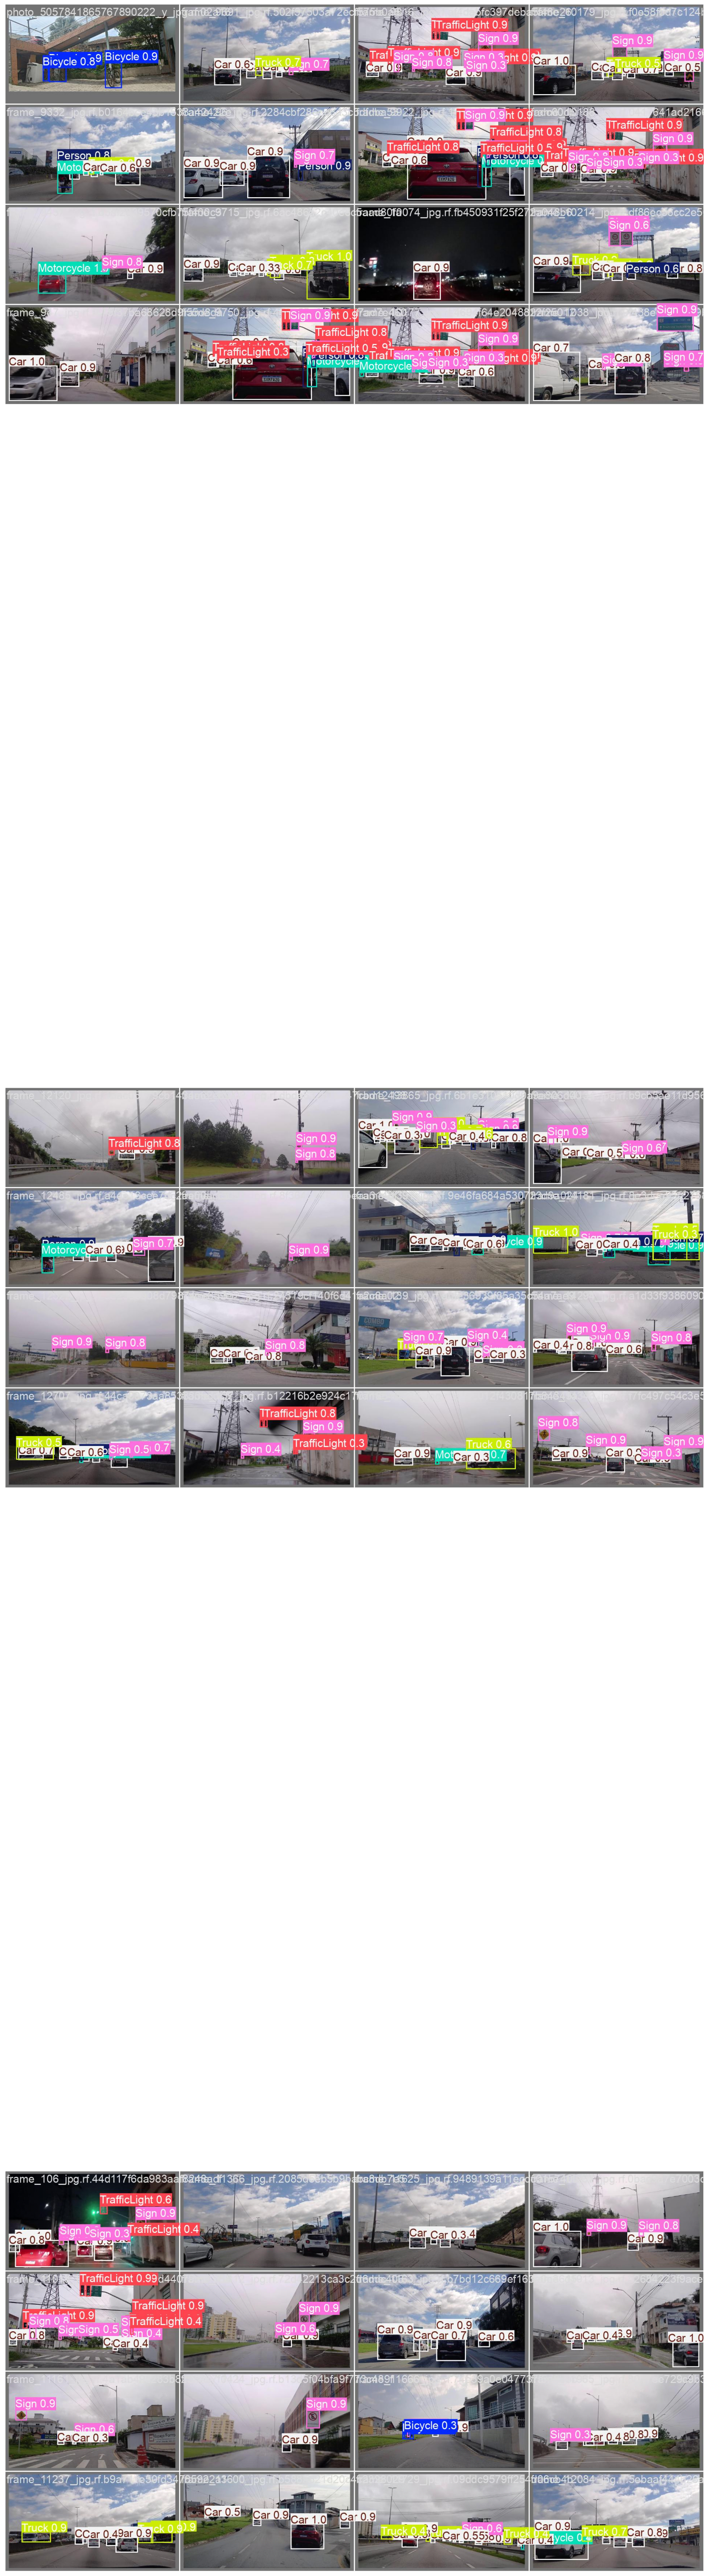

In [15]:
def plot_images(images):
    num_images = len(images)
    rows = num_images
    cols = 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 80))
    for ax in axes.flat:
        ax.axis('off')
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i].imshow(img)
    
    plt.tight_layout()
    plt.show()
    
plot_images(preds)

In [22]:
# Saving results on zip
!zip -r results_yolo11m_custom_dataset.zip yolo11m_finetunned

  adding: yolo11m_finetunned/ (stored 0%)
  adding: yolo11m_finetunned/train/ (stored 0%)
  adding: yolo11m_finetunned/train/confusion_matrix_normalized.png (deflated 20%)
  adding: yolo11m_finetunned/train/train_batch13301.jpg (deflated 13%)
  adding: yolo11m_finetunned/train/args.yaml (deflated 52%)
  adding: yolo11m_finetunned/train/train_batch0.jpg (deflated 5%)
  adding: yolo11m_finetunned/train/PR_curve.png (deflated 10%)
  adding: yolo11m_finetunned/train/val_batch0_pred.jpg (deflated 6%)
  adding: yolo11m_finetunned/train/train_batch2.jpg (deflated 4%)
  adding: yolo11m_finetunned/train/results.csv (deflated 64%)
  adding: yolo11m_finetunned/train/val_batch0_labels.jpg (deflated 6%)
  adding: yolo11m_finetunned/train/labels_correlogram.jpg (deflated 34%)
  adding: yolo11m_finetunned/train/val_batch2_labels.jpg (deflated 7%)
  adding: yolo11m_finetunned/train/val_batch2_pred.jpg (deflated 7%)
  adding: yolo11m_finetunned/train/weights/ (stored 0%)
  adding: yolo11m_finetunned/tr